## Студент: Семенов Владислав, vliusemenov@bk.ru

## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 18:20:10--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.75MB/s    in 1.5s    

2025-03-02 18:20:13 (3.75 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

**Все свои текстовые примечания и ответы я выделял по ходу выполнения ДЗ жирным шрифтом.**

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    return result.values #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    result = coo_array((df.rating, (df.user_id, df.item_id)),
                       shape=(df.user_id.nunique(), df.item_id.nunique()),
                       dtype=np.float64)
    return result # coo_array

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
import scipy


def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    if isinstance(interractions, np.ndarray):
        U, S, V = scipy.linalg.svd(interractions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]
    elif isinstance(interractions, coo_array):
        if n_singular_values == -1:
            n_singular_values = min(interractions.shape[0], interractions.shape[1]) - 1
        U, S, V = scipy.sparse.linalg.svds(interractions, k=n_singular_values)
    return U, np.diag(S), V

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    recommendations = []
    U, S, V = make_svd(interractions, n_singular_values)
    preds_matrix = U @ S @ V
    mat = interractions.toarray() if isinstance(interractions, coo_array) else interractions
    for i in range(mat.shape[0]):
        df = pd.DataFrame(data=(zip(mat[i, :], preds_matrix[i, :])),
                          columns=['init', 'preds'])
        df['preds'] = df['preds'].astype(np.float64)
        df = df[df.init == 0].sort_values(by='preds', ascending=False).head(top_k)
        recommendations.append(df.index.to_numpy())
    return np.array(recommendations) #shape ~ [n_users, top_k]

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

**Предобработаем тестовые данные:**

In [19]:
test_df_grouped = df_test.groupby('user_id')\
    .apply(lambda x: list(x['item_id']), include_groups=False)\
    .reset_index(name='test_interactions')
test_df_grouped.head()

,user_id,test_interactions
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]"
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]"
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4..."


**Функции подсчета метрик (взял с семинара, почти не переписывал):**

In [20]:
def evaluate_recommender(df, model_preds, gt_col="test_interactions", topn=10):
    metric_values = []
    for idx, row in df.iterrows():
        gt_items = row[gt_col][:topn]
        metric_values.append(ndcg_metric(gt_items, row[model_preds]))
    return np.mean(metric_values)


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    ndcg_ = rank_dcg / ideal_dcg
    return ndcg_

In [21]:
import time
import matplotlib.pyplot as plt


def plot_graphs(train_interactions: Union[np.ndarray, coo_array],
                test_df_grouped: pd.DataFrame,
                top_k: int = 100):
    n_singular_values = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    elapsed_times = []
    for n_singular_value in n_singular_values:
        start_time = time.time()
        recs = make_svd_recommendations(train_interactions, n_singular_value, top_k)
        elapsed = time.time() - start_time
        elapsed_times.append(elapsed)
        test_df_grouped['svd_recs'] = test_df_grouped.user_id.apply(lambda x: recs[x].tolist())
        ndcg_scores.append(evaluate_recommender(test_df_grouped, 'svd_recs', topn=top_k))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    ax[0].plot(n_singular_values, ndcg_scores)
    ax[1].plot(n_singular_values, elapsed_times)
    ax[0].set_xlabel('n_singular_values')
    ax[1].set_xlabel('n_singular_values')
    ax[0].set_ylabel('NDCG@100')
    ax[1].set_ylabel('elapsed time (sec)')
    plt.show()
    return ndcg_scores

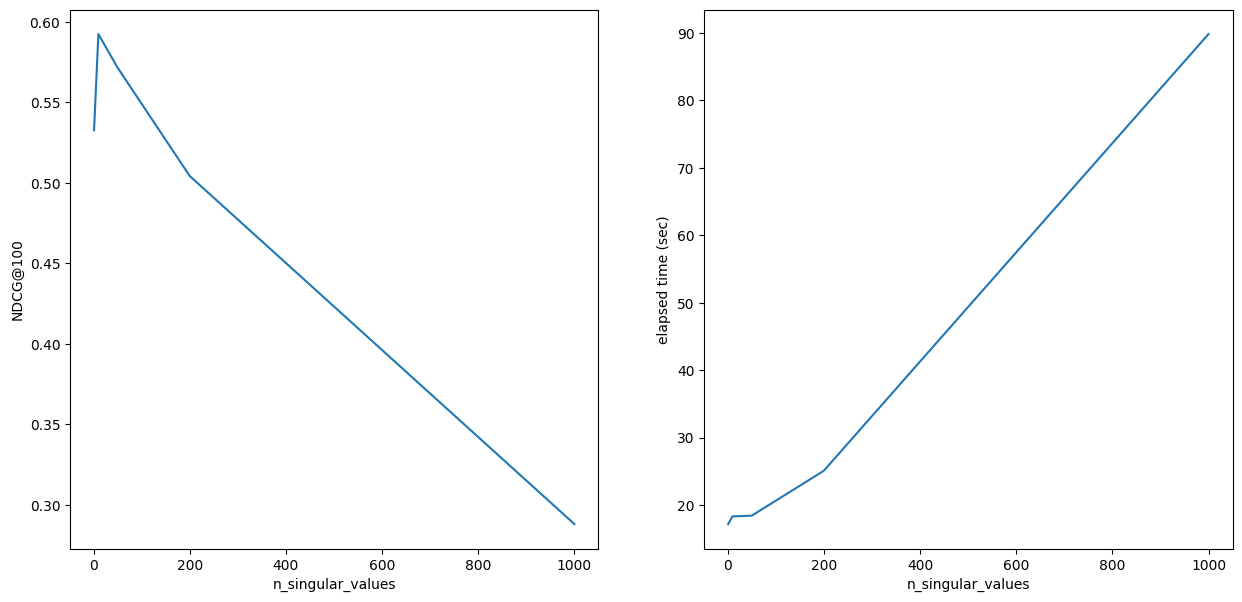

In [22]:
svd_scores = plot_graphs(coo_interactions, test_df_grouped)

**С увеличением n_singular_values время разложения очевидным образом возрастает. При этом рост n_singular_values приводит вначале к росту, а затем к снижению метрики NDCG. Видимо, это связано с тем, что увеличение n_singular_values влечет за собой более точное восстановление исходной матрицы интеракций. Однако слишком точное восстановление не позволит нам правильно опрделить рекомендации из списка фильмов, которые юзер еще не смотрел, потому что воостановленные значения матрицы будут одинаково равны 0. Поэтому нам важно восстанавливать матрицу с неполной точностью.**

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [23]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.7 MB/s eta 0:00:00


**Переписал сигнатуру функции и ассерт под предсказания на тестовом датасете.**

In [24]:
from implicit.als import AlternatingLeastSquares


class ImplicitModel:
    def __init__(self, model):
        self.model = model
        self.trained = False

    def fit(self, interactions: Union[np.ndarray, coo_array]):
        self.train_ratings = scipy.sparse.csr_matrix(interactions)
        self.model.fit(self.train_ratings)
        self.trained = True

    def predict(self, test_df: pd.DataFrame, top_k: int = 100):
        if not self.trained:
            raise ValueError("Model is not fitted. Please, fit the model first")
        users_to_predict = test_df.user_id
        user_recs = self.model.recommend(
            users_to_predict, self.train_ratings[users_to_predict], N=top_k, filter_already_liked_items=True
        )[0]
        return user_recs

    def explain(self, user_id: int, item_id: int) -> tuple:
        if not self.trained:
            raise ValueError("Model is not fitted. Please, fit the model first")
        return self.model.explain(user_id, self.train_ratings, item_id)


def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    df_test: pd.DataFrame,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    als = AlternatingLeastSquares(iterations=10,
                                  factors=n_factors,
                                  alpha=alpha,
                                  regularization=regularization,
                                  calculate_training_loss=True)
    model = ImplicitModel(als)
    model.fit(interactions)
    recommendations = model.predict(df_test, top_k)
    return recommendations #shape ~ [n_users, top_k]

In [25]:
recs = make_als_recommendations(interactions, test_df_grouped)
assert recs.shape == (test_df_grouped.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

**Переберем гиперпараметры:**

In [26]:
import itertools


n_factors = [10, 20, 100, 200]
alpha = [0.01, 0.1, 1]
regularization = [0.001, 0.01, 0.1, 1]

max_ndcg = -np.inf
max_parameters = None
top_k = 100
for fac, alp, reg in itertools.product(n_factors, alpha, regularization):
    als = AlternatingLeastSquares(iterations=10,
                                  factors=fac,
                                  alpha=alp,
                                  regularization=reg,
                                  calculate_training_loss=True)
    test_df_grouped['als_recs'] = make_als_recommendations(interactions,
                                                           test_df_grouped,
                                                           top_k,
                                                           fac,
                                                           alp,
                                                           reg).tolist()
    ndcg = evaluate_recommender(test_df_grouped, 'als_recs', topn=top_k)
    if ndcg > max_ndcg:
        max_ndcg = ndcg
        max_parameters = {'factors': fac, 'alpha': alp, 'reg': reg}
print(f'Maximum NDCG = {max_ndcg}')
print(f'Max NCDG parameters {max_parameters}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Maximum NDCG = 0.5900517407158777
Max NCDG parameters {'factors': 10, 'alpha': 1, 'reg': 0.1}


**Посмотрим на максимальный скор для SVD:**

In [27]:
print(f'Maximum SVD NDCG = {max(svd_scores)}')

Maximum SVD NDCG = 0.5924914658394177


**Таким образом, модель ALS показала себя незначительно лучше SVD.**

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [28]:
test_df_grouped.head()

,user_id,test_interactions,svd_recs,als_recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[928, 2071, 103, 3009, 2350, 2957, 2942, 1979,...","[580, 684, 670, 1417, 2957, 928, 944, 665, 584..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[2985, 2069, 2833, 372, 2424, 2831, 1220, 2400...","[929, 887, 944, 886, 670, 1424, 1053, 2035, 25..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[1377, 2060, 486, 658, 2880, 2255, 2849, 1403,...","[2699, 215, 432, 1173, 399, 3009, 1617, 253, 8..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[2191, 2415, 1594, 286, 1071, 1604, 707, 1026,...","[1038, 2630, 878, 2886, 1394, 877, 2807, 1804,..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[815, 770, 557, 637, 2271, 2183, 108, 2213, 12...","[875, 1167, 877, 2119, 2216, 2588, 889, 1982, ..."


**Загрузим датасет с информацией о фильмах:**

In [29]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', names=['title', 'genres'], engine='python', index_col=0, encoding='latin-1')
movies.head()

,title,genres
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


**Обучим ALS на лучшмх гиперпараметрах и посмотрим, какие фильмы вляиют на выбор юзером конкретного фильма. Юзеров и фильмы выберем по кусочку матрицы интеракций.**

In [30]:
interactions[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
als = AlternatingLeastSquares(iterations=10,
                              factors=10,
                              alpha=1,
                              regularization=0.001,
                              calculate_training_loss=True)
model = ImplicitModel(als)
model.fit(interactions)
user_items = [(8, 0), (4, 5)]
for user, item in user_items:
    explained = model.explain(user, item)[1]
    user_id = user_le.inverse_transform([user])[0]
    item_id = item_le.inverse_transform([item])[0]
    print(f'юзер {user_id} выбрал фильм {movies.loc[item_id].title}, жанр {movies.loc[item_id].genres}')
    print('на выбор юзера могли оказать взаимодействия:')
    for explained_item in explained:
        explained_id = item_le.inverse_transform([explained_item[0]])[0]
        movie = movies.loc[explained_id]
        print(f'{movie.title}, жанр {movie.genres}, вес айтема: {explained_item[1]}')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

юзер 678 выбрал фильм Toy Story (1995), жанр Animation|Children's|Comedy
на выбор юзера могли оказать взаимодействия:
Toy Story (1995), жанр Animation|Children's|Comedy, вес айтема: 0.05902187739988299
Babe (1995), жанр Children's|Comedy|Drama, вес айтема: 0.04787044424386021
Toy Story 2 (1999), жанр Animation|Children's|Comedy, вес айтема: 0.0425624076933723
American Beauty (1999), жанр Comedy|Drama, вес айтема: 0.03598067967265322
Shakespeare in Love (1998), жанр Comedy|Romance, вес айтема: 0.03356580008194411
Matrix, The (1999), жанр Action|Sci-Fi|Thriller, вес айтема: 0.02728412609284003
Braveheart (1995), жанр Action|Drama|War, вес айтема: 0.02301080310812999
E.T. the Extra-Terrestrial (1982), жанр Children's|Drama|Fantasy|Sci-Fi, вес айтема: 0.02196314321666448
Fargo (1996), жанр Crime|Drama|Thriller, вес айтема: 0.021800051932230925
South Park: Bigger, Longer and Uncut (1999), жанр Animation|Comedy, вес айтема: 0.021525458754130724

юзер 674 выбрал фильм Heat (1995), жанр Action

**Нужно отметить, что результаты действительно получиилсь адекватными: для выбранных айтемов мы получили жанрово близкие фильмы и даже фильмы из одной франшизы (например, "История игрушек" и "История игрушек 2" для юзера с id 678)**

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

**1. Бинаризуем все рейтинги (заменим любую интеракцию пользователя на 1):**

In [32]:
def compare_recs(coo_bin_interactions: coo_array):
    svd_recs = make_svd_recommendations(coo_bin_interactions, 10, top_k)
    test_df_grouped['svd_recs'] = test_df_grouped.user_id.apply(lambda x: svd_recs[x].tolist())
    test_df_grouped['als_recs'] = make_als_recommendations(coo_bin_interactions,
                                                           test_df_grouped,
                                                           top_k,
                                                           n_factors=10,
                                                           alpha=1,
                                                           regularization= 0.001).tolist()
    print(f"SVD NDCG = {evaluate_recommender(test_df_grouped, 'svd_recs', topn=top_k)}")
    print(f"ALS NDCG = {evaluate_recommender(test_df_grouped, 'als_recs', topn=top_k)}")

train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x > 0 else 0)
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5789115886651888
ALS NDCG = 0.5738209622833877


**2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0**

In [33]:
train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x >= 4 else 0)
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5645444464941912
ALS NDCG = 0.5903458224055929


**3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1**

In [34]:
train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x >= 4 else -1)
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5762640733788634
ALS NDCG = 0.5969589971994372


**4. Заменим на 1 только рейтинги 4 и 5, рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени (учитывать будем целое число месяцев - так я понял из формулировки задания)**

In [35]:
train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x >= 4 else -1)
train_bin['timedelta'] = (train_bin.datetime.max() - train_bin.datetime).dt.days # разница во времени в днях
train_bin['weight'] = 0.9 ** (train_bin.timedelta // 30) # вес интеракции в зависисмости от месяца
train_bin.rating = train_bin.rating * train_bin.weight
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5782556471171852
ALS NDCG = 0.5987493321005396


**5. Мой вариант: заменим на 1 рейтинги 4 и 5, рейтинг ниже 4 заменим на 0 и добавим сглаживание по времени с недельным интервалом**

In [36]:
# целое число недель
train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x >= 4 else 0)
train_bin['timedelta'] = (train_bin.datetime.max() - train_bin.datetime).dt.days
train_bin['weight'] = 0.9 ** (train_bin.timedelta // 7)
train_bin.rating = train_bin.rating * train_bin.weight
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5762495503283731
ALS NDCG = 0.6060255775381734


In [37]:
# дробное число недель
train_bin = df_train.copy()
train_bin.rating = train_bin.rating.apply(lambda x: 1 if x >= 4 else 0)
train_bin['timedelta'] = (train_bin.datetime.max() - train_bin.datetime).dt.days
train_bin['weight'] = 0.9 ** (train_bin.timedelta / 7)
train_bin.rating = train_bin.rating * train_bin.weight
coo_bin_interactions = df_to_coo(train_bin)
compare_recs(coo_bin_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

SVD NDCG = 0.5749318644790513
ALS NDCG = 0.6025271231311302


**Видно, что модель ALS в целом справилась лучше SVD (при этом для п.1 результаты SVD и ALS практически равны, SVD-разложение даже оказалось чуть лучше). Наибольший скор для ALS получен в п.5 (бинаризация рейтингов по аналогии с п.2 сглаживание по времени с недельным интервалом).**

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

**Оптимизацию я решил не копировать из статьи, а воспользоваться встроенными функциями numpy, которые позволяют ускорить вычисления.**

In [41]:
from sklearn.metrics import mean_squared_error


class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        # инициализируем матрицу регуляризации
        self.eye = np.eye(self.n_factors) * self.reg_coef

    def fit(self, interractions: np.ndarray, n_iterations: int = 10):
        # инициализируем матрицу юзер-фактор (X) и айтем-фактор (Y)
        self.X = np.random.rand(interractions.shape[0], self.n_factors)
        self.Y = np.random.rand(interractions.shape[1], self.n_factors)
        # инициализируем матрицу интеракций P и матрицу уверенности C
        self.P = (interractions > 0).astype(float)
        self.C = 1 + self.alpha * interractions
        for i in range(n_iterations):
            self.X = self._als_step(self.X, self.Y, 'users')
            self.Y = self._als_step(self.Y, self.X, 'items')
            predictions = self.predict()
            # на каждой итерации считаем и выводим MSE относительно матрицы P
            train_mse = self.compute_mse(self.P, predictions)
            print(f"loss on {i} step: {train_mse}")

    def _als_step(self, solve_vecs: np.ndarray, fixed_vecs: np.ndarray, mode: str):
        for idx in range(solve_vecs.shape[0]):
            # если считаем матрицу юзер-фактор, выбираем строку, иначе - столбец
            C_solve_vec = self.C[idx] if mode == 'users' else self.C[:, idx]
            A = np.einsum('fi,i->fi', fixed_vecs.T, C_solve_vec) @ fixed_vecs + self.eye
            A_inv = np.linalg.inv(A)
            p_solve_vec = self.P[idx] if mode == 'users' else self.P[:, idx]
            b = np.einsum('fi,i->fi', fixed_vecs.T, C_solve_vec) @ p_solve_vec
            solve_vecs[idx] = A_inv @ b
        return solve_vecs

    def predict(self):
        # возращаем восстановленную матрицу юзер-айтем
        predicts = self.X.dot(self.Y.T)
        return predicts # shape ~ [n_users, top_k]

    def get_top_k_recs(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы, с которыми юзер взаимодействовал, не входят в рекомендации)
        cleared_preds = []
        dirty_preds = self.predict()
        for user in range(dirty_preds.shape[0]):
            dirty_preds[user] = np.argsort(dirty_preds[user])[::-1]
            user_preds = []
            for item in dirty_preds[user].astype(int):
                # если с айтемом в "грязных" предсказаниях юзер не взаимодейстовал, добавляем этот айтем в рекомендации
                if self.P[user][item] == 0:
                    user_preds.append(item)
                if len(user_preds) == top_k:
                    break
            cleared_preds.append(user_preds)
        return np.array(cleared_preds)

    def compute_mse(self, y_true, y_pred):
        # расчет MSE
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [42]:
%%time
# параметры для максимизации скора я специально не перебирал
model = iALS(n_factors=10, alpha=1, reg_coef=0.001)
model.fit(interactions)

loss on 0 step: 0.3517238310507995
loss on 1 step: 0.24571680975558938
loss on 2 step: 0.2369631623121349
loss on 3 step: 0.23536155629995179
loss on 4 step: 0.23448008856733168
loss on 5 step: 0.2339374449528088
loss on 6 step: 0.2336248846203579
loss on 7 step: 0.23343890840714113
loss on 8 step: 0.2333220482894576
loss on 9 step: 0.23324786073356774
CPU times: user 59.1 s, sys: 30.5 s, total: 1min 29s
Wall time: 52 s


In [43]:
preds = model.get_top_k_recs()
test_df_grouped['my_ials_recs'] = test_df_grouped.user_id.apply(lambda x: preds[x])
evaluate_recommender(test_df_grouped, 'my_ials_recs', topn=100)

0.5893432309733793

**Модель обучается достаточно быстро, при этом ее качество сопоставимо с библиотечной реализацией iALS.**